# Reinforcement Learning

In [1]:
from yahoofinancials import YahooFinancials
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import random

import pandas as pd
from pandas_datareader import data


In [2]:
def get_prices(share_symbol, start_date, end_date,cache_filename='stock_prices.npy'):
    try:
        stock_prices = np.load(cache_filename)
    except IOError:
        share = YahooFinancials(share_symbol)
        stock_hist = share.get_historical_price_data(start_date, end_date,'daily')
        #print(stock_hist)
        stock_prices = [stock_price['open'] for stock_price in stock_hist[share_symbol]['prices']]
        np.save(cache_filename, stock_prices)
    return np.array(stock_prices)

def plot_prices(prices):
    plt.title('Opening stock prices')
    plt.xlabel('day')
    plt.ylabel('price ($)')
    plt.plot(prices)
    #plt.savefig('prices.png')
    plt.show()

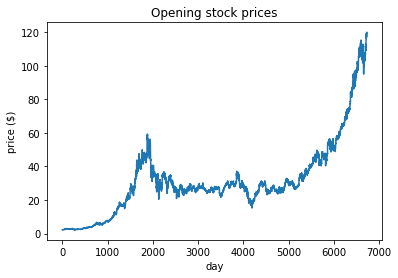

In [3]:
price = get_prices('MSFT', '1992-07-22', '2019-04-07',cache_filename='None')
plot_prices(price)

## Schema for the Decision Policy class

In [4]:
class DecisionPolicy:
    def select_action(self, current_state,step):
        pass
    
    def update_q(self, current_state, action, reward, next_state):
        pass

## Random Decision Policy

In [5]:
class RandomDecisionPolicy(DecisionPolicy):
    def __init__(self, actions):
        self.actions = actions
        
    def select_action(self, current_state,step):
        action = random.choice(self.actions)
        return action

In [6]:
def run_simulation(policy, initial_budget, initial_num_stocks, prices, hist):
    budget = initial_budget
    num_stocks = initial_num_stocks
    share_value = 0
    transitions = list()
    
    for i in range(len(prices) - hist - 1):
        if i % 1000 == 0:
            print('progress {:.2f}%'.format(float(100*i) / (len(prices) -hist - 1)))
        current_state = np.asmatrix(np.hstack((prices[i:i+hist], budget,num_stocks)))
        current_portfolio = budget + num_stocks * share_value
        action = policy.select_action(current_state,i)
        share_value = float(prices[i + hist])
        
        if action == 'Buy' and budget >= share_value:
            budget -= share_value
            num_stocks += 1
        elif action == 'Sell' and num_stocks > 0:
            budget += share_value
            num_stocks -= 1
        else:
            action = 'Hold'
        new_portfolio = budget + num_stocks * share_value
        reward = new_portfolio - current_portfolio
        next_state = np.asmatrix(np.hstack((prices[i+1:i+hist+1], budget,num_stocks)))
        transitions.append((current_state, action, reward, next_state))
        policy.update_q(current_state, action, reward, next_state)
    portfolio = budget + num_stocks * share_value
    return portfolio

In [7]:
def run_simulations(policy, budget, num_stocks, prices, hist):
    num_tries = 10
    final_portfolios = list()
    for i in range(num_tries):
        final_portfolio = run_simulation(policy, budget, num_stocks, prices,hist)
        final_portfolios.append(final_portfolio)
        print('Final portfolio: ${}'.format(final_portfolio))
    plt.title('Final Portfolio Value')
    plt.xlabel('Simulation #')
    plt.ylabel('Net worth')
    plt.plot(final_portfolios)
    plt.show()

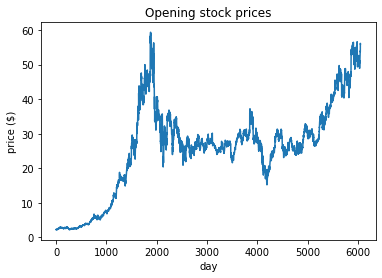

progress 0.00%
progress 16.55%
progress 33.10%
progress 49.65%
progress 66.20%
progress 82.75%
progress 99.30%
Final portfolio: $100824.85926246643
progress 0.00%
progress 16.55%
progress 33.10%
progress 49.65%
progress 66.20%
progress 82.75%
progress 99.30%
Final portfolio: $100471.71029567719
progress 0.00%
progress 16.55%
progress 33.10%
progress 49.65%
progress 66.20%
progress 82.75%
progress 99.30%
Final portfolio: $100828.96251964569
progress 0.00%
progress 16.55%
progress 33.10%
progress 49.65%
progress 66.20%
progress 82.75%
progress 99.30%
Final portfolio: $100583.8963727951
progress 0.00%
progress 16.55%
progress 33.10%
progress 49.65%
progress 66.20%
progress 82.75%
progress 99.30%
Final portfolio: $101142.11260414124
progress 0.00%
progress 16.55%
progress 33.10%
progress 49.65%
progress 66.20%
progress 82.75%
progress 99.30%
Final portfolio: $102693.7333574295
progress 0.00%
progress 16.55%
progress 33.10%
progress 49.65%
progress 66.20%
progress 82.75%
progress 99.30%
Fin

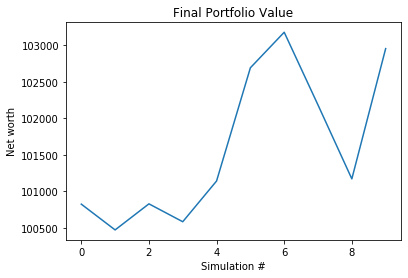

In [8]:
prices = get_prices('MSFT', '1992-07-22', '2016-07-22',cache_filename='None')
plot_prices(prices)
actions = ['Buy', 'Sell', 'Hold']
hist = 3
policy = RandomDecisionPolicy(actions)
budget = 100000.0
num_stocks = 0
run_simulations(policy, budget, num_stocks, prices, hist)

## Q-Learning Decision Policy

In [9]:
class QLearningDecisionPolicy(DecisionPolicy):
    def __init__(self, actions, input_dim):
        self.epsilon = 0.95
        self.gamma = 0.3
        self.actions = actions
        output_dim = len(actions)
        h1_dim = 20
        self.x = tf.placeholder(tf.float32, [None, input_dim])
        self.y = tf.placeholder(tf.float32, [output_dim])
        W1 = tf.Variable(tf.random_normal([input_dim, h1_dim]))
        b1 = tf.Variable(tf.constant(0.1, shape=[h1_dim]))
        h1 = tf.nn.relu(tf.matmul(self.x, W1) + b1)
        W2 = tf.Variable(tf.random_normal([h1_dim, output_dim]))
        b2 = tf.Variable(tf.constant(0.1, shape=[output_dim]))
        self.q = tf.nn.relu(tf.matmul(h1, W2) + b2)
        loss = tf.square(self.y - self.q)
        self.train_op = tf.train.AdagradOptimizer(0.01).minimize(loss)
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        
    def select_action(self, current_state, step):
        threshold = min(self.epsilon, step / 1000.)
        if random.random() < threshold:
            # Exploit best option with probability epsilon
            action_q_vals = self.sess.run(self.q, feed_dict={self.x:current_state})
            action_idx = np.argmax(action_q_vals)
            action = self.actions[action_idx]
        else:
            # Explore random option with probability 1 - epsilon
            action = self.actions[random.randint(0, len(self.actions) - 1)]
        return action
    
    def update_q(self, state, action, reward, next_state):
        action_q_vals = self.sess.run(self.q, feed_dict={self.x: state})
        next_action_q_vals = self.sess.run(self.q, feed_dict={self.x:next_state})
        next_action_idx = np.argmax(next_action_q_vals)
        current_action_idx = self.actions.index(action)
        action_q_vals[0, current_action_idx] = reward + self.gamma *next_action_q_vals[0, next_action_idx]
        action_q_vals = np.squeeze(np.asarray(action_q_vals))
        self.sess.run(self.train_op, feed_dict={self.x: state, self.y:action_q_vals})

progress 0.00%
progress 16.55%
progress 33.10%
progress 49.65%
progress 66.20%
progress 82.75%
progress 99.30%
Final portfolio: $101648.03930091858
progress 0.00%
progress 16.55%
progress 33.10%
progress 49.65%
progress 66.20%
progress 82.75%
progress 99.30%
Final portfolio: $101784.15231513977
progress 0.00%
progress 16.55%
progress 33.10%
progress 49.65%
progress 66.20%
progress 82.75%
progress 99.30%
Final portfolio: $101251.53839492798
progress 0.00%
progress 16.55%
progress 33.10%
progress 49.65%
progress 66.20%
progress 82.75%
progress 99.30%
Final portfolio: $100761.85995960236
progress 0.00%
progress 16.55%
progress 33.10%
progress 49.65%
progress 66.20%
progress 82.75%
progress 99.30%
Final portfolio: $101646.69789409637
progress 0.00%
progress 16.55%
progress 33.10%
progress 49.65%
progress 66.20%
progress 82.75%
progress 99.30%
Final portfolio: $102558.7161283493
progress 0.00%
progress 16.55%
progress 33.10%
progress 49.65%
progress 66.20%
progress 82.75%
progress 99.30%
Fi

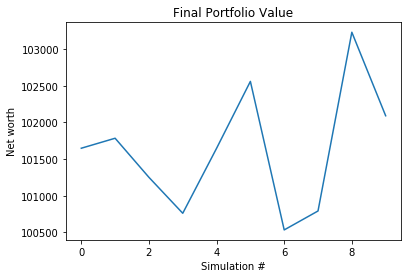

In [10]:
policy = RandomDecisionPolicy(actions)
run_simulations(policy, budget, num_stocks, prices, hist)